# Diagramming

Schema diagrams are essential tools for understanding and designing relational databases. They provide a visual representation of tables and their relationships, making complex schemas easier to comprehend at a glance.

Several diagramming notations have been used for designing relational schemas, as already introduced in the section on [Relational Theory](../20-concepts/01-relational.md). Common notations include:

* **Chen's Entity-Relationship (ER) Notation**: Uses rectangles for entities and diamonds for relationships
* **Crow's Foot Notation**: Uses symbols at line endpoints to indicate cardinality (one, many, optional)
* **UML Class Diagrams**: Adapted from object-oriented modeling

DataJoint uses its own diagramming notation that is specifically designed for working with directed acyclic graphs (DAGs) and makes relationship types immediately visible through line styles.

## DataJoint Diagram Structure

A DataJoint schema is depicted as a **Directed Acyclic Graph (DAG)**, where:

* **Nodes** represent tables in the database
* **Edges** represent foreign key constraints between tables
* **Direction** always flows from parent (referenced) to child (referencing) tables

The key constraint in DataJoint is that **foreign keys cannot form cycles** - you cannot have a chain of foreign keys that loops back to a starting table. This constraint ensures that:

1. Schemas can always be visualized as top-to-bottom workflows
2. Data dependencies are clear and unambiguous
3. Queries can follow predictable patterns

Tables at the top of the diagram are independent entities (no foreign keys to other tables), while tables lower in the diagram depend on tables above them.

## Quick Reference: Line Styles

Before diving into details, here's a quick reference for interpreting DataJoint diagrams:

| Line Style | Symbol | Meaning | Semantic Relationship | Example |
|------------|--------|---------|----------------------|---------|
| **Thick Solid** | ━━━ | One-to-one | **Extension**: Child extends parent | Customer ━━━ CustomerNotes |
| **Thin Solid** | ─── | One-to-many | **Containment**: Child belongs to parent | Customer ─── Account |
| **Dashed** | ┄┄┄ | One-to-many | **Reference**: Child references parent | Account ┄┄┄ Bank |

**Key Principle**: Solid lines mean the parent's identity becomes part of the child's identity. Dashed lines mean the child maintains independent identity.

**Critical Distinction**: 
- **Thin solid** → Many children can belong to one parent (containment)
- **Thick solid** → Only one child can extend each parent (extension)

## Example: Project Assignment Schema

Let's start with a simple schema called "projects" depicting employees, projects, and assignments of projects to employees. This is a classic many-to-many relationship:

* **Employee** and **Project** are independent entities (no foreign keys)
* **Assignment** is an association table that links employees to projects
* One employee can be assigned to multiple projects
* One project can have multiple employees assigned to it


In [2]:
import datajoint as dj

dj.conn()


schema = dj.Schema("projects")

@schema
class Employee(dj.Manual):
    definition = """
    employee_id : int
    ---
    employee_name : varchar(60)
    """

@schema
class Project(dj.Manual):
    definition = """
    project_code  : varchar(8)
    ---
    project_title : varchar(50)
    start_date : date
    end_date : date
    """
    
@schema
class Assignment(dj.Manual):
    definition = """
    -> Employee
    -> Project
    ---
    percent_effort : decimal(4,1) unsigned
    """

[2025-10-08 19:08:07,939][INFO]: DataJoint 0.14.6 connected to dev@db:3306


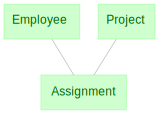

In [3]:
dj.Diagram(schema)

### Interpreting the Diagram

In this diagram, observe the following features:

* **Green boxes with underlined names**: These are the tables. The underline indicates these are independent entities (dimensions) with their own primary keys.
* **Thin solid lines**: Both edges use thin solid lines, indicating that the foreign keys from `Assignment` are part of its primary key.
* **Converging pattern**: The `Assignment` table has two foreign keys converging into it, which is the visual signature of an association table creating a many-to-many relationship.
* **Top-to-bottom layout**: Independent entities (`Employee` and `Project`) are at the top, and the dependent table (`Assignment`) is at the bottom.

**Interactive Features**: In Jupyter notebooks, you can hover over any table in the diagram to see its complete definition, including all attributes and constraints.


# Understanding Line Styles

The most important feature of DataJoint diagrams is how **line styles indicate relationship types**. There are three types of lines, each conveying specific information about how tables are related.

## The Three Line Styles

### 1. Thick Solid Line (━━━)

**Meaning**: One-to-one relationship where the foreign key constitutes the **entire primary key** of the child table.

**Conceptual Model**: The child entity is a **specialized extension or elaboration** of the parent entity. The child doesn't have its own independent identity—it IS the parent, just with additional information attached.

**Characteristics**:
- Child table shares the exact same primary key as the parent
- Creates the strongest form of dependency and unified identity
- Child inherits the parent's complete identity
- Perfect for adding optional or modular information to an entity
- Enables direct joins across multiple levels of hierarchy

**Example Use Cases**:
- Workflow sequences: Order → Shipment → Delivery (each step extends the order)
- Optional entity extensions: Customer → CustomerPreferences (preferences extend customer)
- Modular data splits: Experiment → ExperimentNotes (notes extend experiment)
- One-to-one specializations where child adds detail without changing identity

**Think of it as**: "Child extends parent" or "Child specializes parent"

### 2. Thin Solid Line (───)

**Meaning**: One-to-many relationship where the foreign key is **part of** (but not all of) the child's primary key.

**Conceptual Model**: The child entity **belongs to or is contained within** the parent entity. The child has its own identity, but only within the context of its parent. Multiple children can exist for each parent, each identified by the parent's key plus additional distinguishing attributes.

**Characteristics**:
- Child table has a composite primary key: parent's PK + additional field(s)
- Creates hierarchical ownership or containment structures
- Child's identity is contextualized by parent (e.g., "Account #3 of Customer #42")
- Parent's primary key "cascades" down, becoming part of child's identity
- Enables direct joins to ancestors without intermediate tables

**Example Use Cases**:
- Hierarchies: Study → Subject → Session → Scan (sessions belong to subjects)
- Ownership: Customer → Account (accounts belong to customers)
- Containment: Folder → File (files are contained in folders)
- Parts-of: Order → OrderItem (items are parts of orders)

**Think of it as**: "Child belongs to parent" or "Child is contained in parent"

### 3. Dashed Line (- - - -)

**Meaning**: One-to-many relationship where the foreign key is a **secondary attribute** (not part of the primary key).

**Conceptual Model**: The child entity **references or associates with** the parent but maintains complete independence. The child has its own identity that is unrelated to the parent, and the parent is just one of many attributes describing the child.

**Characteristics**:
- Child table has its own independent primary key
- Foreign key appears below the line (in secondary attributes)
- Relationship is "looser" - no identity cascade
- Cannot skip intermediate tables in joins
- Relationship can be more easily changed or made optional

**Example Use Cases**:
- Optional associations: Product → Manufacturer (product exists independently)
- References that might change: Employee → Department (employee might transfer)
- Loose couplings: Document → Author (document has independent identity)
- When child entity has independent identity from parent

**Think of it as**: "Child references parent" or "Child is loosely associated with parent"

## Summary: The Conceptual Framework

Understanding the semantic difference between line types:

| Line Type | Semantic Relationship | Identity | Cardinality |
|-----------|----------------------|----------|-------------|
| **Thick Solid** | Extension/Specialization | Shared | One-to-one |
| **Thin Solid** | Containment/Belonging | Contextualized | One-to-many |
| **Dashed** | Reference/Association | Independent | One-to-many |

**Key Insight**: Solid lines (thick or thin) indicate that the parent's identity becomes part of the child's identity, either completely (thick) or partially (thin). Dashed lines indicate the child maintains its own independent identity.

## Key Conceptual Distinction: Containment vs. Extension

The choice between thin and thick solid lines reflects a fundamental design decision about the **semantic relationship** between entities:

### Thin Lines → Containment/Belonging (One-to-Many)

When you use a thin solid line, you're saying:
- *"The child belongs to the parent"*
- *"Multiple children can exist within each parent"*
- *"The child's identity includes the parent's identity"*

**Example**: A `Session` belongs to a `Subject`. You can have Session 1, Session 2, Session 3 all belonging to the same subject. The sessions are identified as "Subject 42, Session 1" and "Subject 42, Session 2".

```
-> Subject
session : int
```

**Result**: Composite primary key `(subject_id, session)` → Thin solid line

### Thick Lines → Extension/Specialization (One-to-One)

When you use a thick solid line, you're saying:
- *"The child extends the parent with additional information"*
- *"There can be at most one child for each parent"*
- *"The child and parent share the same identity"*

**Example**: A `Shipment` extends an `Order`. Once an order is placed, it may or may not be shipped. If it's shipped, there's exactly one shipment record that shares the order's identity.

```
-> Order
```

**Result**: Primary key is just `order_id` (inherited) → Thick solid line

### Visual Summary

```
Parent Table
     │
     ├─── (thin solid) ──→  Child has: Parent PK + own fields → "belongs to"
     │
     └═══ (thick solid) ══→  Child has: Parent PK only → "extends"
```

### When to Choose Which

Ask yourself: "Can there be multiple children for each parent?"

- **Yes** → Use thin solid line (child belongs to parent)
- **No** → Use thick solid line (child extends parent)

## Concrete Examples: Containment vs. Extension

Let's illustrate the distinction with two concrete scenarios:

### Scenario 1: Experiment Sessions (Containment - Thin Line)

In a lab, an experiment has multiple sessions. Each session belongs to its experiment:

```python
class Experiment(dj.Manual):
    definition = """
    experiment_id : int
    ---
    experiment_name : varchar(100)
    """

class Session(dj.Manual):
    definition = """
    -> Experiment         # Part of primary key
    session : int         # Additional PK component
    ---
    session_date : date
    """
```

**Relationship**: Session **belongs to** Experiment
- Can have Session 1, Session 2, Session 3... all for the same experiment
- Session identity: "Experiment 5, Session 2"
- **Thin solid line** in diagram
- Think: "sessions are contained within experiments"

### Scenario 2: Experiment Notes (Extension - Thick Line)

Sometimes you want to add optional notes to an experiment without cluttering the main table:

```python
class Experiment(dj.Manual):
    definition = """
    experiment_id : int
    ---
    experiment_name : varchar(100)
    """

class ExperimentNotes(dj.Manual):
    definition = """
    -> Experiment         # This IS the primary key
    ---
    notes : varchar(4000)
    added_date : timestamp
    """
```

**Relationship**: ExperimentNotes **extends** Experiment
- Can have at most one notes entry per experiment
- Notes identity: same as experiment (shares `experiment_id`)
- **Thick solid line** in diagram
- Think: "notes are an optional extension of experiment"

### The Decision Tree

```
Do multiple children exist for each parent?
│
├─ YES ──→ Thin Solid Line (Containment/Belonging)
│          Child PK: parent_pk + own_field(s)
│          Example: One experiment has many sessions
│
└─ NO ───→ Thick Solid Line (Extension/Specialization)
           Child PK: parent_pk only
           Example: One experiment has zero or one notes entry
```

## Visual Examples of Each Line Style

Let's create schemas that demonstrate each type of line. We'll use variations of a simple customer-account relationship.


### Example 1: Dashed Line (Secondary Foreign Key)


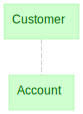

In [4]:
schema_dashed = dj.Schema('diagram_dashed')

@schema_dashed
class Customer(dj.Manual):
    definition = """
    customer_id : int
    ---
    name : varchar(50)
    """

@schema_dashed  
class Account(dj.Manual):
    definition = """
    account_number : int
    ---
    -> Customer
    balance : decimal(10,2)
    """

dj.Diagram(schema_dashed)


**Dashed line** from `Customer` to `Account`: The foreign key `customer_id` is in the secondary attributes of `Account` (below the `---` line). Each account has its own independent ID (`account_number`), and the relationship to customer is secondary. 

This represents a **reference or loose association** - the account maintains its own identity independent of the customer. This is a one-to-many relationship (one customer can have many accounts), and accounts could theoretically be reassigned to different customers by updating the foreign key (though in practice, we prefer delete-and-insert over updates).

### Example 2: Thin Solid Line (Composite Primary Key)


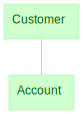

In [5]:
schema_thin = dj.Schema('diagram_thin')

@schema_thin
class Customer(dj.Manual):
    definition = """
    customer_id : int
    ---
    name : varchar(50)
    """

@schema_thin
class Account(dj.Manual):
    definition = """
    -> Customer
    account_number : int
    ---
    balance : decimal(10,2)
    """

dj.Diagram(schema_thin)


**Thin solid line** from `Customer` to `Account`: The foreign key `customer_id` is part of `Account`'s primary key (above the `---` line). The primary key of `Account` is the composite `(customer_id, account_number)`. 

This represents **containment or belonging** - each account belongs to and is identified within the context of its customer. Account #3 means nothing on its own; it's "Account #3 of Customer #42". This is a one-to-many relationship with identity cascade, creating a hierarchical structure where accounts are owned by customers.

### Example 3: Thick Solid Line (Primary Key is Foreign Key)


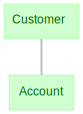

In [6]:
schema_thick = dj.Schema('diagram_thick')

@schema_thick
class Customer(dj.Manual):
    definition = """
    customer_id : int
    ---
    name : varchar(50)
    """

@schema_thick
class Account(dj.Manual):
    definition = """
    -> Customer
    ---
    balance : decimal(10,2)
    """

dj.Diagram(schema_thick)


**Thick solid line** from `Customer` to `Account`: The foreign key IS the entire primary key of `Account`. The primary key of `Account` is just `customer_id` (inherited from `Customer`). 

This represents an **extension or specialization** - the account extends the customer entity with additional financial information. Customer and account share the same identity; they are one-to-one. This is useful when you want to modularize data (separate customer info from account info) while maintaining that each customer can have at most one account. Note that `Account` is no longer underlined in the diagram, indicating it's not an independent dimension but rather an extension of `Customer`.

# What Diagrams Show and Don't Show

Understanding the limitations of diagram notation is just as important as understanding what they do show.

## What Diagrams Clearly Indicate

✅ **Line Style (Thick/Thin/Dashed)**:
- Whether foreign keys are in primary key or secondary attributes
- Whether relationships are one-to-one (thick) or one-to-many (thin/dashed)
- Whether primary keys cascade through relationships (solid lines)

✅ **Direction of Dependencies**:
- Which table depends on which (arrows point from parent to child)
- Workflow order (top to bottom)
- Which tables are independent vs. dependent

✅ **Table Types**:
- Underlined names = independent entities (dimensions)
- Non-underlined names = dependent entities (no independent identity)
- Color coding for table tiers (Manual, Lookup, Imported, Computed, etc.)

✅ **Association Patterns**:
- Converging lines indicate association tables
- Many-to-many relationships (two foreign keys in primary key)

## What Diagrams Don't Show

❌ **Nullable Foreign Keys**:
- Whether a foreign key is nullable (allows NULL values)
- Cannot distinguish between mandatory and optional relationships
- Must examine table definition to see nullable modifiers

❌ **Secondary Unique Constraints**:
- Unique indexes on secondary attributes
- Could convert a one-to-many into a one-to-one relationship
- Not visible in the diagram at all

❌ **Actual Attribute Names**:
- Only table names are shown (hover to see attributes)
- Foreign key field names might be renamed via projection
- Must inspect definition to see exact field names

❌ **Data Types and Constraints**:
- Cannot see CHECK constraints, default values, etc.
- Must examine table definition for these details

❌ **Composite Unique Constraints**:
- Complex uniqueness rules beyond the primary key
- May fundamentally change relationship semantics

## Best Practice

**Design Principle**: DataJoint users generally avoid secondary unique constraints when the primary key structure can enforce uniqueness. Making foreign keys part of the primary key (creating solid lines) provides two major benefits:

1. **Visual Clarity**: The relationship type is immediately obvious from the diagram
2. **Query Simplicity**: Primary keys cascade through foreign keys, enabling direct joins between distant tables


# Practical Tips for Working with Diagrams

## How to Read a Schema Quickly

When encountering a new schema diagram, follow this systematic approach:

1. **Identify Independent Entities** (top of diagram, underlined)
   - These are your starting points for data entry
   - No dependencies on other tables
   
2. **Trace the Solid Lines** (thick or thin)
   - Follow the cascading primary keys
   - Understand which tables can be joined directly
   
3. **Spot Association Tables** (converging patterns)
   - Look for tables with multiple foreign keys in their primary key
   - These represent many-to-many relationships
   
4. **Check Line Thickness**
   - Thick lines = one-to-one relationships (workflow steps, optional extensions)
   - Thin lines = one-to-many hierarchies (ownership, containment)
   - Dashed lines = one-to-many loose associations

## Designing with Diagrams in Mind

When designing a new schema, consider:

**Use Solid Lines When**:
- Building hierarchical structures (Study → Subject → Session)
- Creating workflow sequences (Order → Ship → Deliver)
- You want to enable direct joins across levels

**Use Dashed Lines When**:
- Child has independent identity from parent
- Relationship might change frequently
- You don't want primary key cascade

**Use Thick Lines When**:
- Creating one-to-one relationships
- Extending entities with optional information
- Modeling sequential workflows

## Diagram-Driven Queries

The diagram structure directly informs query patterns:

**Solid Line Paths** (direct joins possible):
```python
# If Study → Subject → Session are connected by solid lines:
Study * Session  # Valid join, no need to include Subject
```

**Dashed Line Paths** (must include intermediate tables):
```python
# If Study ---> Subject (dashed), Subject → Session (solid):
Study * Subject * Session  # Must include Subject
```

## Common Patterns at a Glance

| Pattern | Line Type | Primary Key Structure | Use Case |
|---------|-----------|----------------------|----------|
| Independent entities | None (top level) | Own PK | Starting points |
| Hierarchy | Thin solid | Parent PK + own field(s) | Containment, ownership |
| Sequence | Thick solid | Parent PK only | Workflows, one-to-one |
| Secondary reference | Dashed | Own PK | Association |
| Association table | Multiple thin solid | Multiple parent PKs | Many-to-many |

## Interactive Exploration

**In Jupyter Notebooks**:
- **Hover** over tables to see complete definitions (also works if you save the diagram as a SVG file)

**Filtering Diagrams**:
```python
# Show only specific tables
dj.Diagram(Table1) + dj.Diagram(Table2)

# Show table and its immediate dependencies
dj.Diagram(Table1) - 1

# Show table and its immediate up to seven layears up in the graph
dj.Diagram(Table1) - 7

# Show table and what depends on it  
dj.Diagram(Table1) + 1

# Show table and what depends on it up to seven layers down in the graph
dj.Diagram(Table1) + 7

# Show table and what depends on it up to seven layers down in the graph
dj.Diagram(Table1) + 7

```

## Summary

DataJoint diagrams are powerful tools for:
- **Understanding** existing schemas quickly
- **Communicating** design decisions visually
- **Planning** query strategies
- **Validating** relationship structures

The key is understanding that **line style encodes relationship semantics**: thick solid lines for one-to-one, thin solid lines for cascading one-to-many, and dashed lines for non-cascading one-to-many relationships. This visual language makes complex schemas comprehensible at a glance.
